# Up-to-date model training process

2022-07-13

Zooey Nguyen

IMPORTANT: We have to manually create separate HDF5 files for training, validation, and testing. The DataMaker doesn't do the split itself. Use HSC_v6 step 2A for these files.

Returns three generator objects that iterates over each dataset split. Can be used directly in model.fit() and will batch appropriately during training without eating up all memory.

Note that the first epoch will take a little time to show the progress bar, I think it's related to GPU usage.

2022-07-25

- I am making this a more general model training template so people can easily save everything the same way.
- Batching on full dataset, callbacks, our shared metrics.
- Dataset is not shuffled for now, so that we do not have to save inputs and outputs when we save predictions.

## Setup

In [ ]:
import os
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
from DataMaker import *

In [ ]:
LATENT_DIM = 16
IMAGE_SHAPE = (5, 127, 127)
BATCH_SIZE = 1024
EPOCHS = 10
GB_LIMIT = 10
CHECKPOINTS_TO_SAVE = 10

In [ ]:
DATASET_NAME = "HSC_v6"
MODEL_TYPE = "dummy"
MODEL_VERSION = "v1"

model_id = '_'.join([DATASET_NAME, MODEL_TYPE, MODEL_VERSION])
dir_model = os.path.join('/models', model_id, 'model')
dir_checkpoints = os.path.join('/models', model_id, 'checkpoints')
dir_logs = os.path.join('/logs', model_id)
dir_predictions = os.path.join('/predictions', model_id)

print(dir_model)
print(dir_checkpoints)
print(dir_logs)
print(dir_predictions)

os.makedirs(dir_model, exist_ok=True)
os.makedirs(dir_checkpoints, exist_ok=True)
os.makedirs(dir_logs, exist_ok=True)
os.makedirs(dir_predictions, exist_ok=True)

## Allocate GPU

Make sure to check others' current usage on Aurora in terminal using `watch nvidia-smi`. Set your `GB_LIMIT` accordingly, in gigabytes. Aurora has 50GB of memory.

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=GB_LIMIT*1000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

## Data

Create the shuffled and batched data generators.

In [31]:
args_gen = {'X_key': 'image',
    'y_key': 'specz_redshift',
    'scaler': False,
    'labels_encoding': False,
    'batch_size': BATCH_SIZE,
    'mode': 'train',
    'shuffle': True}

start_path = "/data/HSC/HSC_v6/step2A/127x127/five_band_image127x127_"
end_path = "_with_metadata_with_scaled.hdf5"
TRAIN_PATH = start_path + "training" + end_path
VAL_PATH = start_path + "validation" + end_path
TEST_PATH = start_path + "testing" + end_path

In [32]:
train_hf = h5py.File(TRAIN_PATH)
print(list(train_hf.keys()))
print(train_hf['image'].shape)
TRAIN_SIZE = train_hf['image'].shape[0]

['coord', 'dec', 'g_cmodel_mag', 'g_cmodel_magsigma', 'i_cmodel_mag', 'i_cmodel_magsigma', 'image', 'object_id', 'r_cmodel_mag', 'r_cmodel_magsigma', 'ra', 'scaled_mags', 'skymap_id', 'specz_dec', 'specz_flag_homogeneous', 'specz_mag_i', 'specz_name', 'specz_ra', 'specz_redshift', 'specz_redshift_err', 'y_cmodel_mag', 'y_cmodel_magsigma', 'z_cmodel_mag', 'z_cmodel_magsigma']
(229120, 5, 127, 127)


In [33]:
train_gen = HDF5ImageGenerator(src=TRAIN_PATH, **args_gen)
val_gen = HDF5ImageGenerator(src=VAL_PATH, **args_gen)
test_gen = HDF5ImageGenerator(src=TEST_PATH, **args_gen)

In [36]:
train_gen._indices

array([     0,      1,      2, ..., 229117, 229118, 229119])

example: item from the training generator

(1024, 5, 127, 127)
(1024,)


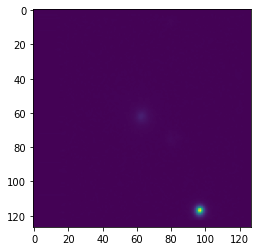

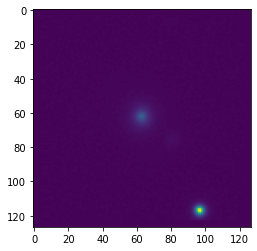

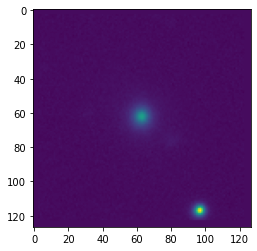

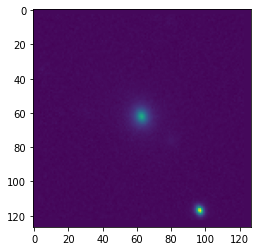

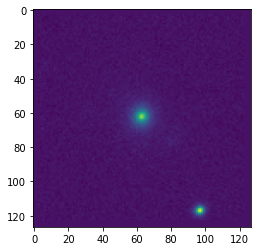

In [34]:
import matplotlib.pyplot as plt

print(train_gen.__getitem__(0)[0].shape)
print(train_gen.__getitem__(0)[1].shape)
for i in range(5):
    plt.figure()
    plt.imshow(train_gen.__getitem__(0)[0][0][i])

## Choose losses and metrics

We need these for callbacks and training the model.

In [144]:
LOSS = tf.keras.losses.MeanSquaredError()
METRICS = [
    tf.keras.metrics.MeanAbsoluteError()
]

## Callbacks

What we'd like to save during training.

- Metrics logs per epoch to visualise in TensorBoard.
- Model weights per epoch.
- Predictions and corresponding metrics per prediction per epoch.

These are the simple built-in callbacks.

In [90]:
from tensorflow.keras.callbacks import Callback, TensorBoard, ModelCheckpoint

logs_callback = TensorBoard(log_dir=dir_logs)
weights_callback = ModelCheckpoint(filepath=os.path.join(dir_checkpoints, 'weights_epoch{epoch}.hdf5'),
                                   save_freq=int(EPOCHS/CHECKPOINTS_TO_SAVE),
                                   save_weights_only=True
                                  )

This was my first attempt at a Data Collector.
- Use the "fake metric" approach that allows collection of true and predicted values: https://stackoverflow.com/questions/47079111/create-keras-callback-to-save-model-predictions-and-targets-for-each-batch-durin/59697739#59697739
- Must add this dummy metric to the metrics list during model compilation.
- ONLY USE THIS ONE FOR UNSHUFFLED DATASET.
- THIS WILL ONLY SAVE PREDICTIONS ON BATCH, NO INDICES ARE SAVED.
- IT IS ACTUALLY HELL TO TRY AND ACCESS MODEL DATA FROM INSIDE THE CALLBACK. It is simply not what Callback was designed for. They used to have the functionality by saving inputs/outputs/targets in the self.model attributes, and made the CONSCIOUS choice to remove this access. Maybe something to do with the principle of callbacks.

In [91]:
# class DataCallback(Callback):
#     """Callback to operate on batch data from metric."""

#     def __init__(self, log_dir, save_freq, dataset):
#         """Offer a metric to access batch data."""
#         super().__init__()
#         self.log_dir = log_dir
#         self.save_freq = save_freq
#         self.save_epoch = False
#         self.y_true = None
#         self.y_pred = None
#         self.dataset = dataset
#         self.num_items = dataset.num_items
        
#         self.predictions = []
#         self.filename = None

#     def set_model(self, model):
#         """Initialize variables when model is set."""
#         self.y_true = tf_nan(model.output.dtype)
#         self.y_pred = tf_nan(model.output.dtype)
#         super().set_model(model)

#     def collector(self, y_true, y_pred):
#         """Dummy metric to collect the true and predicted values."""
#         self.y_true.assign(y_true)
#         self.y_pred.assign(y_pred)
#         return 0.0
    
#     def on_epoch_begin(self, epoch, logs=None):
#         if epoch % self.save_freq != 0:
#             self.save_epoch = False
#             return
#         self.save_epoch = True
#         self.predictions = []
#         csvname = 'predictions_epoch' + str(epoch) + '.csv'
#         self.filename = os.path.join(self.log_dir, csvname)

#     def on_train_batch_end(self, _batch, _logs=None):
#         if self.save_epoch is False:
#             return
#         self.predictions.append(self.y_pred.numpy())

#     def on_epoch_end(self, epoch, logs=None):
#         if self.save_epoch is False:
#             return
#         self.predictions = np.concatenate(self.predictions)
#         np.savetxt(self.filename, self.predictions)

#     def on_train_end(self, _logs=None):
#         """Clean up."""
#         del self.y_true, self.y_pred


# def tf_nan(dtype):
#     """Create NaN variable of proper dtype and variable shape for assign()."""
#     return tf.Variable(float("nan"), dtype=dtype, shape=tf.TensorShape(None))

In [92]:
# data_callback = DataCallback(log_dir=dir_predictions,
#                             save_freq=int(EPOCHS/CHECKPOINTS_TO_SAVE))

This is the slower but more coherent way to save model predictions.
- Takes in the data generator that we want to save for and predicts on the entire thing at the end of each epoch.
- Lots of computation to redo predictions at end of epoch.
- Allows shuffling during training but consistent order to predictions.
- Saves predictions simply, one CSV file per epoch.

In [98]:
class DataCallback(Callback):
    def __init__(self, log_dir, save_freq, dataset):
        """Predict on entire given dataset at the end of epoch."""
        super().__init__()
        self.log_dir = log_dir
        self.save_freq = save_freq
        self.dataset = dataset
        self.num_items = dataset.num_items
        
    def set_model(self, model):
        """Gain access to the model."""
        super().set_model(model)

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.save_epoch != 0:
            return
        csvname = 'predictions_epoch' + str(epoch) + '.csv'
        filename = os.path.join(self.log_dir, csvname)
        print(f"Saving prediction data to {filename}.")
        saved_values = np.empty(self.num_items)
        for x, y in dataset:
            preds = self.model.predict(dataset, verbose=1)
            loss = 
        # if we would like to save individual losses here,
        # we will need to access both the true values and the
        # predicted values, and the actual loss function itself.
        np.savetxt(filename, preds)

In [99]:
data_callback = DataCallback(log_dir=os.path.join(dir_checkpoints),
                             save_freq=int(EPOCHS/CHECKPOINTS_TO_SAVE),
                             dataset=val_gen
                            )

## Model

here's a little dummy dum essentially linear model that doesnt do anything

but more importantly, it actually trains AND doesn't crash everything when we restrict its GPU usage.

### Define model

In [145]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam', loss=LOSS, metrics=METRICS)

### Train model

In [101]:
model.fit(
    train_gen,
    epochs=EPOCHS,
    callbacks=[logs_callback, weights_callback, data_callback],
    validation_data=val_gen,
    verbose=1)

Epoch 1/10
224/224 [==============================] - ETA: 0s - loss: 51.9071

KeyboardInterrupt: 

### Save final model and results

In [16]:
print(dir_model)

/models/HSC_v6_dummy_v1/model


In [18]:
model.save(dir_model)

INFO:tensorflow:Assets written to: /models/HSC_v6_dummy_v1/model/assets


In [80]:
savedmodel = tf.keras.models.load_model(dir_model, compile=False)
savedmodel.compile(optimizer='adam', loss='mse', metrics=[data_callback.collector])

In [136]:
valpreds = savedmodel.predict(val_gen, verbose=1)

28/28 [==============================] - 332s 12s/step


In [147]:
valpreds.shape

(28641, 1)

In [108]:
preds = savedmodel.predict(X, verbose=1)

32/32 [==============================] - 0s 2ms/step


## Results

### Evaluate model

In [ ]:
from metrics import *

In [ ]:
5*BATCH_SIZE

In [25]:
preds = pd.read_csv(os.path.join(dir_predictions, 'predictions_epoch0.csv'), header=None)
preds

,0
0,7.961232
1,1.835950
2,1.916332
3,4.317524
4,1.432101
...,...
229115,-0.723320
229116,0.200722
229117,0.052343
229118,-0.481097
